   Unnamed: 0        Date  Adj Close     Close      High       Low      Open  \
0           0  1980-03-17   2.296798  3.291227  3.344743  3.291227  0.000000   
1           1  1980-03-18   2.306134  3.304606  3.358122  3.304606  0.000000   
2           2  1980-03-19   2.306134  3.304606  3.304606  3.304606  3.304606   
3           3  1980-03-20   2.306134  3.304606  3.358122  3.304606  0.000000   
4           4  1980-03-21   2.362154  3.384880  3.438396  3.384880  0.000000   

    Volume  
0  41109.0  
1   9343.0  
2      0.0  
3  10277.0  
4   8409.0  
         Unnamed: 0     Adj Close         Close          High           Low  \
count  11291.000000  11198.000000  11174.000000  11196.000000  11164.000000   
mean    5645.000000     63.609130     72.026945     72.503100     71.665079   
std     3259.575279     52.266247     51.259828     51.550735     51.011632   
min        0.000000      2.259452      3.237711      3.237711      3.237711   
25%     2822.500000     19.224636     27.50000

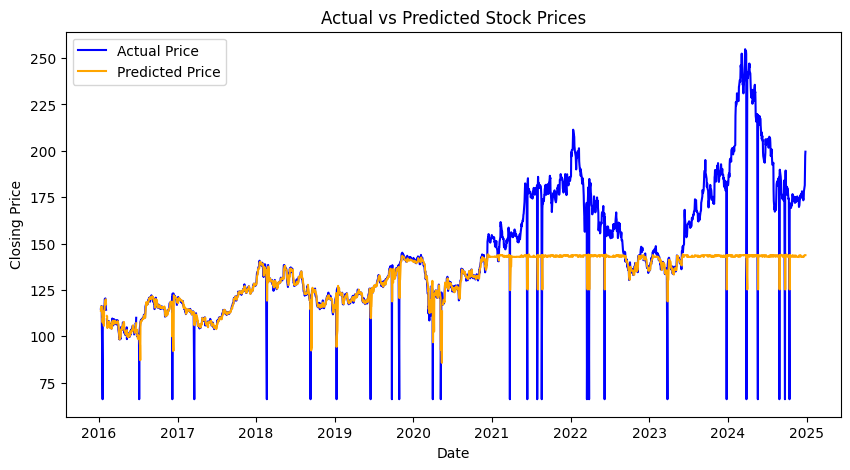

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

#sd - stock data

sd = pd.read_csv("stock-data.csv")

print(sd.head())
print(sd.describe())
print(sd.info())

print(sd.isnull().sum())

sd = sd.drop(columns=['Unnamed: 0'])
print(sd.head())
sd['Date'] = pd.to_datetime(sd['Date'])

numeric_features = sd.select_dtypes(include=np.number).columns
imputer = SimpleImputer(strategy='median')
sd_imputed = pd.DataFrame(imputer.fit_transform(sd[numeric_features]), columns=numeric_features)
sd_imputed['Date'] = sd['Date']
sd_imputed = sd_imputed.set_index('Date')

sd_imputed['lag_1'] = sd_imputed['Close'].shift(1)
sd_imputed['lag_5'] = sd_imputed['Close'].shift(5)


sd_imputed['ma_5'] = sd_imputed['Close'].rolling(window=5).mean()
sd_imputed['ma_10'] = sd_imputed['Close'].rolling(window=10).mean()

sd_imputed['volatility_5'] = sd_imputed['Close'].rolling(window=5).std()

sd_imputed.dropna(inplace=True)

X = sd_imputed[['lag_1', 'lag_5', 'ma_5', 'ma_10', 'volatility_5']]
y = sd_imputed['Close']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE: {rmse}')

direction_pred = np.sign(y_pred[1:] - y_pred[:-1])
direction_actual = np.sign(y_test.values[1:] - y_test.values[:-1])
directional_accuracy = (direction_pred == direction_actual).mean() * 100
print(f'Directional Accuracy: {directional_accuracy}%')

plt.figure(figsize=(10,5))
plt.plot(y_test.index, y_test, label='Actual Price', color='blue')
plt.plot(y_test.index, y_pred, label='Predicted Price', color='orange')
plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()






